In [706]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
import sys
import seaborn as sns
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import LeakyReLU
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

In [707]:
def remove_variable_with_0_variance(df):
    key_list = df.keys()
    var_list = []
    name_list = []
    for key in key_list:
        var_list.append(df[key].var())
        name_list.append(key)
        if df[key].var() == 0:
            df = df.drop(columns = key)
    return df

In [708]:
def remove_min_max(df):
    m = 0
    list_of_att = []
    for key in df.keys():
        if key[:-4]+'Min' in df.keys():
            list_of_att.append(key)
    for att in list_of_att:
        df = df.drop(columns = [att[:-4]+'Min',att[:-4]+'Max'])
    return df

In [709]:
def plot_variances_of_min_max(df):
    m = 0
    list_of_att = []
    for key in df.keys():
        if key[:-4]+'Min' in df.keys():
            list_of_att.append(key)
            list_of_att.append(key[:-4]+'Min')
            list_of_att.append(key[:-4]+'Max')
    plt.figure(figsize=(20,20))
    data = df.loc[:,list_of_att]
    corr = data.corr()
    ax = sns.heatmap(
    corr
)

In [710]:
def normalize_data(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [711]:
def calc_acc_and_rmse(predictions,test_target):
    acc_2 = 0
    acc_5 = 0
    total = 0
    error = 0
    for i in range(len(predictions)):
        error+=(predictions[i]-test_target[i])**2
        if abs((predictions[i]-test_target[i])/(test_target[i]+1))<0.02:
            acc_2 += 1
        total += 1
        if abs((predictions[i]-test_target[i])/(test_target[i]+1))<0.05:
            acc_5 += 1
    error = error/len(predictions)
    error**0.5
    print('acc_with_2%: '+str(acc_2/total),'acc_with_5%: '+str(acc_5/total),'RMSE: '+str(error**0.5))
    return acc_2/total,error**0.5

In [712]:
def normalize_and_split_data_from_data_frame_randomly(df,ratio):
    msk = np.random.rand(len(df)) < ratio
    target = df['FF']
    df = normalize_data(df)
    train = df.drop(columns ='FF')
    train_data = train[msk]
    test_data = train[~msk]
    train_target = target[msk].to_numpy()
    test_target = target[~msk].to_numpy()
    return train_data,test_data,train_target,test_target

In [713]:
def normalize_and_split_data_from_data_frame(df,number_of_samples_in_train):
    target = df['FF']
    df = normalize_data(df)
    no = number_of_samples_in_train
    train = df.drop(columns ='FF')
    train_data = train[:no]
    test_data = train[no:]
    train_target = target[:no].to_numpy()
    test_target = target[no:].to_numpy()
    return train_data,test_data,train_target,test_target

In [714]:
def ensemble(list_of_models,test_data):
    list_of_predictions=[]
    for model in list_of_models:
        list_of_predictions.append(model.predict(test_data))
    final_prediction =np.sum(list_of_predictions,axis=0)
    return final_prediction/len(list_of_models)
    
    

In [715]:
def make_net(train,height,width):
    NN_model = Sequential()
    NN_model.add(Dense(width, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))
    for i in range(height - 1):
        NN_model.add(Dense(width, kernel_initializer='normal',activation='relu'))
        
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
    return NN_model

# We first do an analysis of how the min-max versions of attributes are correlated and if they are we remove the min-max versions and keep only the means.

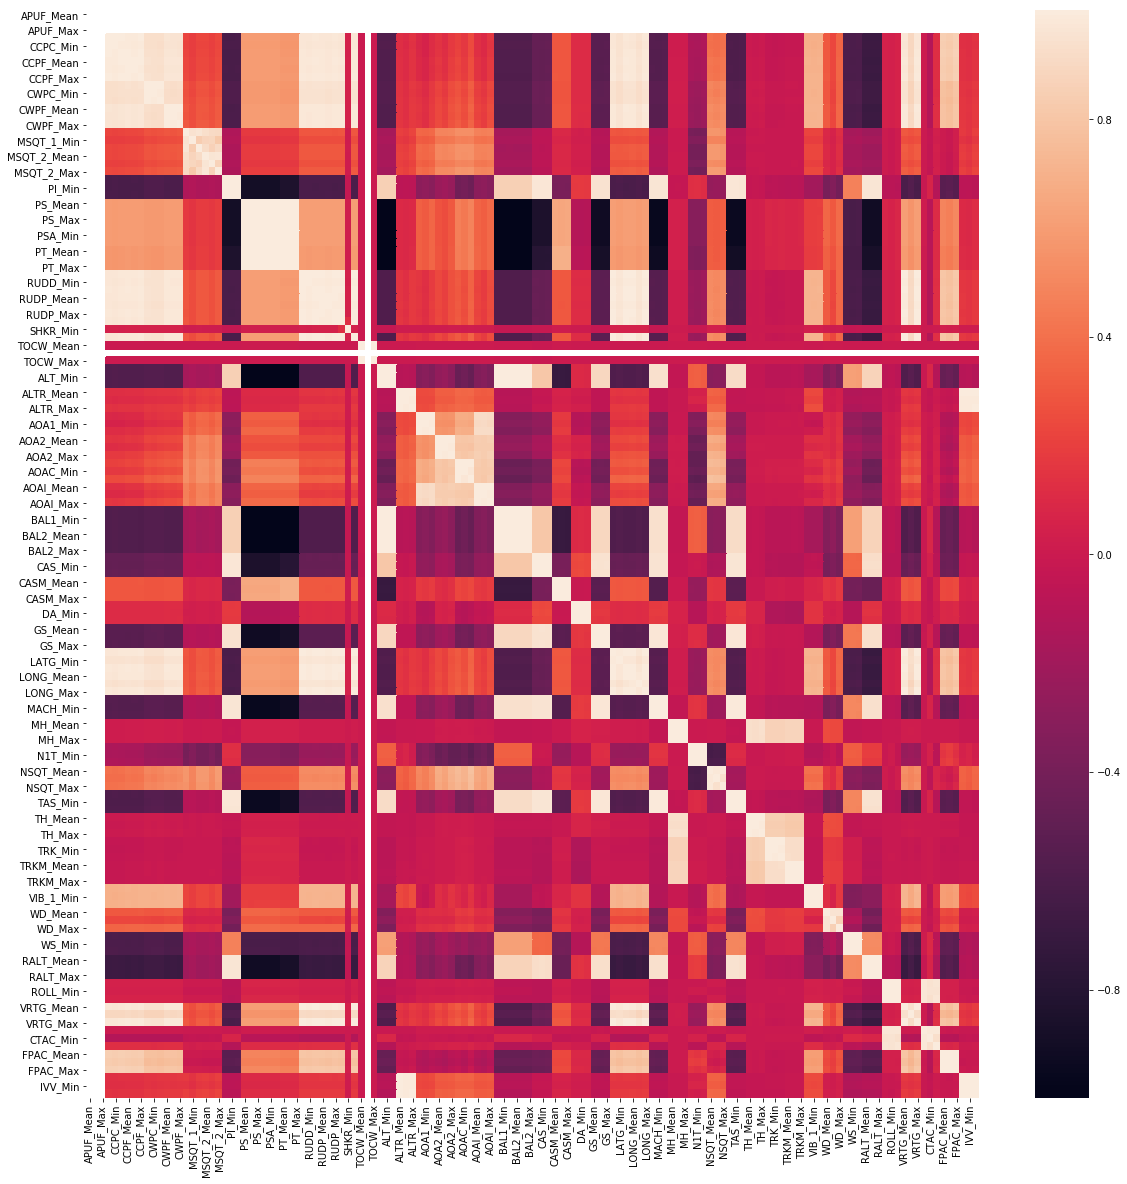

In [184]:
df =  pd.read_pickle('PH_data_one.df')
df = df.drop(columns = ['Flight_instance_ID','ACID'])
plot_variances_of_min_max(df)

# Next we inspect which kind of split is best for training and validation,random or deterministic

In [742]:
#Code for deterministic split using flight order
df =  pd.read_pickle('PH_data_one.df')
df = df.drop(columns = ['Flight_instance_ID','ACID'])
df = remove_variable_with_0_variance(df)
df = remove_min_max(df)
train_data,test_data,train_target,test_target = normalize_and_split_data_from_data_frame(df,80000)

In [745]:
iowa_model = DecisionTreeRegressor(random_state=1)
rf_model = RandomForestRegressor(random_state=1)

In [746]:
iowa_model.fit(train_data, train_target)
predictions = iowa_model.predict(test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.468263266712612 acc_with_5%: 0.6891798759476223 RMSE: 735.3773518547815


(0.468263266712612, 735.3773518547815)

In [727]:
#Code for random split
df =  pd.read_pickle('PH_data_one.df')
df = df.drop(columns = ['Flight_instance_ID','ACID'])
df = remove_variable_with_0_variance(df)
df = remove_min_max(df)
train_data,test_data,train_target,test_target = normalize_and_split_data_from_data_frame_randomly(df,0.8)

In [728]:
iowa_model = DecisionTreeRegressor(random_state=1)
rf_model = RandomForestRegressor(random_state=1)

In [729]:
iowa_model.fit(train_data, train_target)
predictions = iowa_model.predict(test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.8989072287504001 acc_with_5%: 0.9485163001234511 RMSE: 164.05658818228426


(0.8989072287504001, 164.05658818228426)

In [219]:
importance_list = list(zip(train_data.columns, iowa_model.feature_importances_))
#print(importance_list)
new_list = (sorted(importance_list,key=lambda x: x[1]))
from math import log
testList2 = [(elem1, log(elem2)) for elem1, elem2 in new_list if elem2!=0]



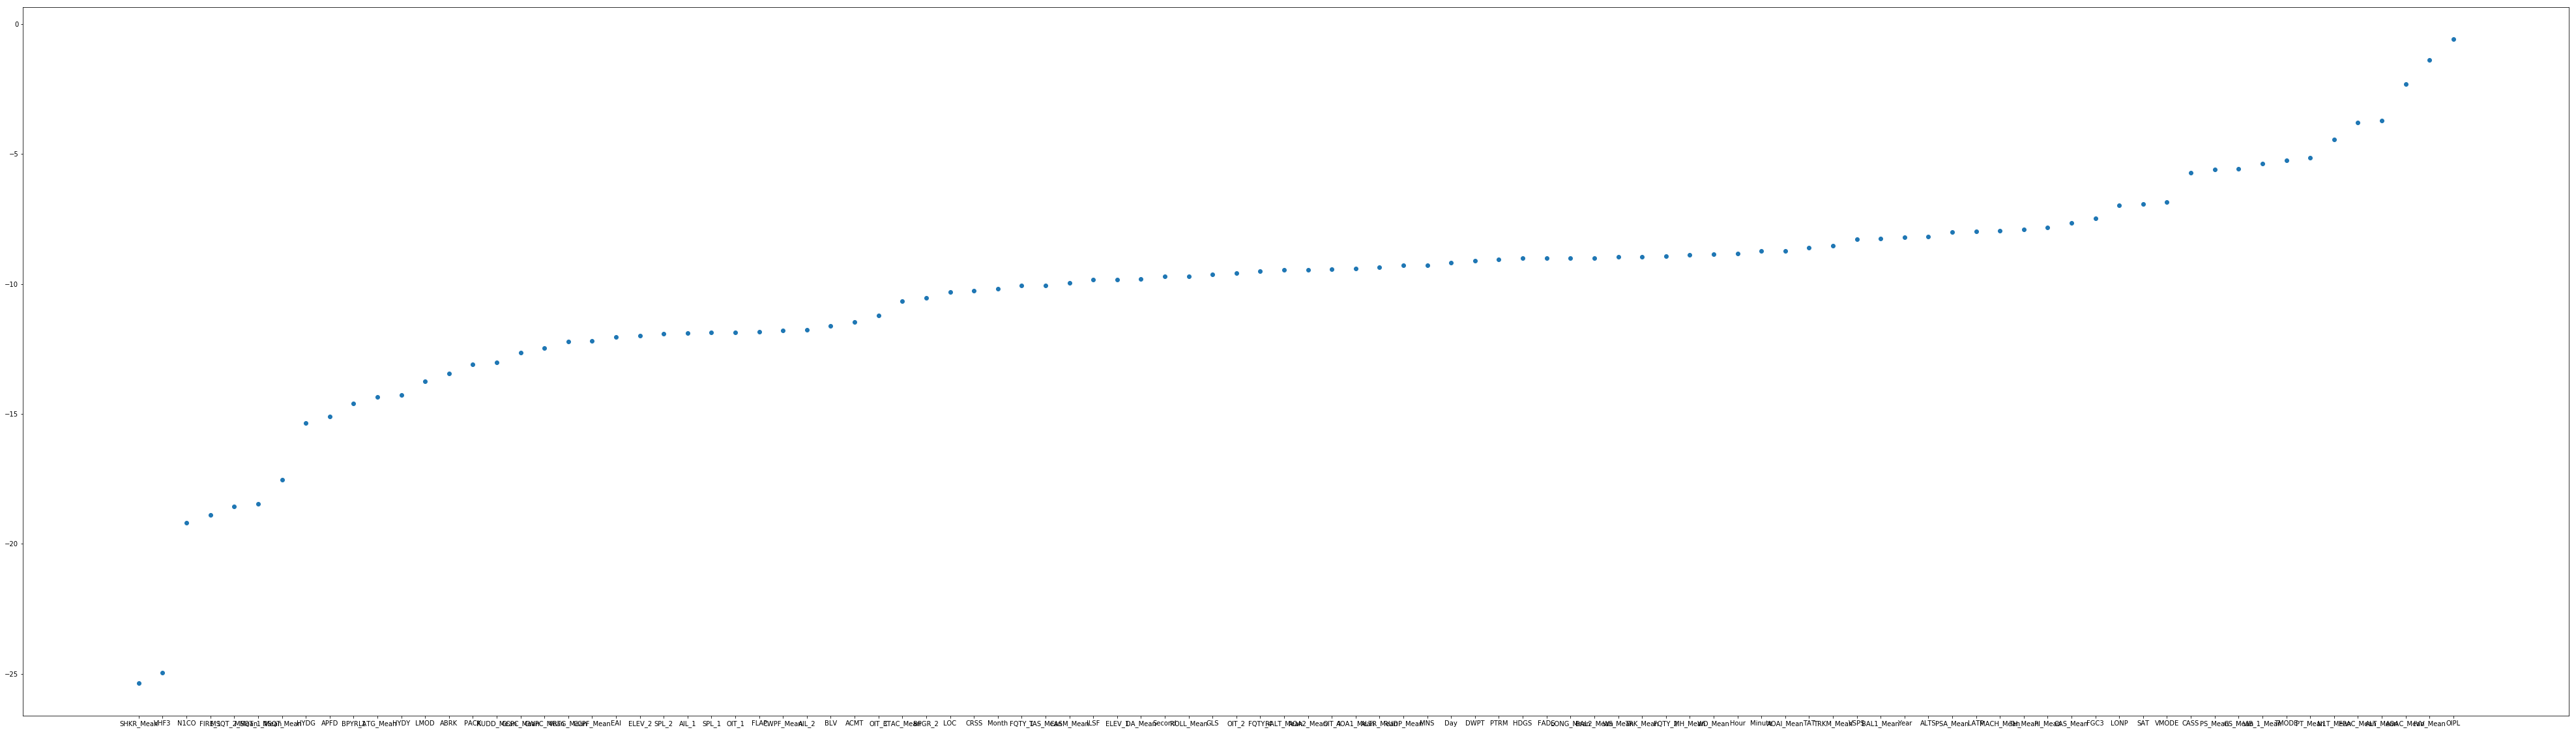

In [225]:
plt.figure(figsize=(70,20))
plt.scatter(*zip(*testList2))
plt.show()

# The Random Forest Regressor giving higher accuracy was expected

In [736]:
rf_model.fit(train_data, train_target)
predictions = rf_model.predict(test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.4986905582356995 acc_with_5%: 0.7169882839421089 RMSE: 669.1222819329723


(0.4986905582356995, 669.1222819329723)

# Now we try to combine two random forest models

In [733]:
#Trying to use random ensemble of two random forest classifier
rf_model_2 = RandomForestRegressor(random_state=0)
rf_model_2.fit(train_data, train_target)
predictions = ensemble([rf_model_2,rf_model],test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.4966919365954514 acc_with_5%: 0.7569951757408684 RMSE: 639.6527977229019


(0.4966919365954514, 639.6527977229019)

In [734]:
rf_model_3 = RandomForestRegressor(random_state=3)
rf_model_3.fit(train_data, train_target)
predictions = ensemble([rf_model_2,rf_model,rf_model_3],test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.4912818745692626 acc_with_5%: 0.721605789110958 RMSE: 636.0509549680163


(0.4912818745692626, 636.0509549680163)

In [735]:
X_train, X_test, y_train, y_test = normalize_and_split_data_from_data_frame(df[0:80000],64000)

In [737]:
model = xgb.XGBRegressor()
model.fit(train_data,train_target)

[13:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [739]:
predictions = model.predict(test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.3034803583735355 acc_with_5%: 0.5677463818056513 RMSE: 554.6744797359878


(0.3034803583735355, 554.6744797359878)

# We see that XGBoost give inferior performance and hence do hyperparameter tuning.

In [564]:
model3 = xgb.XGBRegressor(max_depth=8,min_child_weight=4,random_state=1)
model3.fit(train_data,train_target)

[11:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [740]:
predictions = model3.predict(data=test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.50723638869745 acc_with_5%: 0.7628876636802205 RMSE: 595.9574203063295


(0.50723638869745, 595.9574203063295)

In [747]:
predictions = iowa_model.predict(test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.468263266712612 acc_with_5%: 0.6891798759476223 RMSE: 735.3773518547815


(0.468263266712612, 735.3773518547815)

# The ensemble of decision-tree and XGBoost is very nice

In [748]:
predictions = np.sum([model3.predict(data=test_data),iowa_model.predict(test_data)],axis = 0)/2
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.5574776016540317 acc_with_5%: 0.778394210889042 RMSE: 612.1570689614778


(0.5574776016540317, 612.1570689614778)

# For optimization of XGBOOST we do GRID SEARCH

In [540]:
#Remember to change
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,10)
    for min_child_weight in range(4,10)
]

min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    model = xgb.XGBRegressor(max_depth=max_depth,min_child_weight=min_child_weight)
    #print(dtest.num_row())
    model.fit(X_train,y_train)
    #print(len(prediction))
    prediction = model.predict(data = X_test)
    _,rmse = calc_acc_and_rmse(prediction,y_test)
    if rmse<min_rmse:
        min_rmse = rmse
        best_params = (max_depth,min_child_weight)

CV with max_depth=4, min_child_weight=4
[10:58:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
acc_with_2%: 0.363375 acc_with_5%: 0.5939375 RMSE: 345.3298043412693
CV with max_depth=4, min_child_weight=5
[10:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
acc_with_2%: 0.3636875 acc_with_5%: 0.5869375 RMSE: 344.3159024276028
CV with max_depth=4, min_child_weight=6
[10:59:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
acc_with_2%: 0.3619375 acc_with_5%: 0.5844375 RMSE: 345.99501477632464
CV with max_depth=4, min_child_weight=7
[10:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
acc_with_2%: 0.36125 acc_with_5%: 0.588375 RMSE: 340.6632603267989
CV with max_depth=4, min_child_weight=8
[10:59:55] WARN

acc_with_2%: 0.4939375 acc_with_5%: 0.679125 RMSE: 306.14227124861816


In [541]:
print(best_params)

(7, 9)


In [590]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
min_rmse = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    model = xgb.XGBRegressor(subsample = subsample,colsample_bynode=colsample,max_depth=7 ,min_child_weight=9 )
    model.fit(X_train,y_train)
    prediction = model.predict(data = X_test)
    if rmse<min_rmse:
        min_rmse = rmse
        best_params = (subsample, colsample)
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

[11:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [591]:
print(best_params
     )

(1.0, 1.0)


# NEURAL NETWORK

In [ ]:
def best_net_finder(list_of_width,list_of_height):
    for width in list_of_width:
        for height in list_of_height:
            NN_model = make_net(height,width)
            for epoch in range(3):
                NN_model.fit(train, train_target, epochs=1, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
                error = 0
                total = 0
                acc_2 = 0
                acc_5 = 0
                predictions = NN_model.predict(test)
                for i in range(len(predictions)):
                    error+=(predictions[i]-test_target[i])**2
                    if abs((predictions[i]-test_target[i])/(test_target[i]))<0.02:
                        acc_2 += 1
                    total += 1
                    if abs((predictions[i]-test_target[i])/(test_target[i]))<0.05:
                        acc_5 += 1
                error = error/len(predictions)
                error**0.5

                print(acc_2,acc_5,total,acc_2/total,acc_5/total,error**0.5,height,width,epoch)

In [721]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [722]:
model_list = []
acc_list = []
for i in range(10):
    new_model = make_net(X_train,6,256)
    new_model.fit(train_data[0:64000], train_target[0:64000], epochs=4, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
    predictions = new_model.predict(train_data[64000:])
    acc_list.append(calc_acc_and_rmse(predictions,train_target[64000:]))
    model_list.append(new_model)
    print(calc_acc_and_rmse(predictions,train_target[64000:]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_400 (Dense)            (None, 256)               27648     
_________________________________________________________________
dense_401 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_402 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_403 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_404 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_405 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_406 (Dense)            (None, 1)                 257       
Total para

Train on 51200 samples, validate on 12800 samples
Epoch 1/4
51200/51200 [==============================] - 19s 373us/step - loss: 1125218.2463 - mean_absolute_error: 470.6278 - val_loss: 968903.3692 - val_mean_absolute_error: 782.9233

Epoch 00001: val_loss did not improve from 702932.07655
Epoch 2/4
51200/51200 [==============================] - 14s 280us/step - loss: 116449.7170 - mean_absolute_error: 237.8001 - val_loss: 850670.2083 - val_mean_absolute_error: 753.3420

Epoch 00002: val_loss did not improve from 702932.07655
Epoch 3/4
51200/51200 [==============================] - 14s 280us/step - loss: 95251.2192 - mean_absolute_error: 215.1052 - val_loss: 833242.7519 - val_mean_absolute_error: 733.4033

Epoch 00003: val_loss did not improve from 702932.07655
Epoch 4/4
51200/51200 [==============================] - 14s 278us/step - loss: 84893.7043 - mean_absolute_error: 200.5300 - val_loss: 834482.7866 - val_mean_absolute_error: 750.9608

Epoch 00004: val_loss did not improve from 


Epoch 00003: val_loss did not improve from 545404.68875
Epoch 4/4
51200/51200 [==============================] - 14s 275us/step - loss: 87517.2435 - mean_absolute_error: 201.6717 - val_loss: 691222.6773 - val_mean_absolute_error: 588.1039

Epoch 00004: val_loss did not improve from 545404.68875
acc_with_2%: 0.1655 acc_with_5%: 0.3724375 RMSE: [607.5632]
acc_with_2%: 0.1655 acc_with_5%: 0.3724375 RMSE: [607.5632]
(0.1655, array([607.5632], dtype=float32))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_449 (Dense)            (None, 256)               27648     
_________________________________________________________________
dense_450 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_451 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_452 (D

In [723]:
predictions = ensemble(model_list,test_data)
calc_acc_and_rmse(predictions,test_target)

acc_with_2%: 0.17498277050310132 acc_with_5%: 0.4573053066850448 RMSE: [559.63965]


(0.17498277050310132, array([559.63965], dtype=float32))